In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import measure
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate,probabilistic_hough_line

import os
import pandas as pd

print(cv2.__version__)

4.5.1


In [3]:
file_names = os.listdir("images")
file_names = ["images\{}".format(name) for name in file_names]

cb_images =list()
cropped_images= list()
original_images = list()
# loading images, keeping different
for file_name in file_names:
    image = cv2.imread(file_name)
    cropped_image= image[40:550,130:650]
    cropped_image[0:30,0:30]= 0
    cropped_images.append(cropped_image.copy())
    blurred_image = cv2.GaussianBlur(cropped_image,(13,13),0)
    cb_images.append(blurred_image)
    
 

In [4]:

def find_best_circle(img):
    """
    returns circles found by hough circles
    """
    found_circles = cv2.HoughCircles(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY), cv2.HOUGH_GRADIENT,2.0,minDist=190,
                                    param1=104,param2=400,minRadius=220,maxRadius=250)
    if found_circles is not None:
        found_circles = np.round(found_circles[0, :]).astype("int")
        return found_circles

def compute_centroid(img,blob_area):
    """
        given an image with a blob and the area of the blob it computes the centroid of the blob.
    """
    x_accumulator = y_accumulator=0
    for index_i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[index_i,j]>= 60:
                x_accumulator += index_i
                y_accumulator += j 

    return int(np.rint(y_accumulator/blob_area)),int(np.rint(x_accumulator/blob_area))


def compute_rotation_angle(delta_x,delta_y):
    """
    given delta x and delta y, the difference of a point1 and point2, it computes how many degrees we have to rotate to have the point on the y-axis of the cartesian
    plane with origin exactly on the point2

    """
    res = np.arctan2(delta_y,delta_x)*180/np.pi
    if delta_y>=0 and delta_x>=0:
        return res+90
    elif delta_y>=0 and delta_x<=0:
        return res+90
    elif delta_y<=0 and delta_x>=0:
        return np.abs(90+res)
    elif delta_y<=0 and delta_x<=0:
        return res+90


In [5]:

circular_cav_nums = list()
rotated_images= list()
centers = list()
for i in range(0,len(cb_images)):
    focus = cb_images[i].copy()
    # original = cv2.cvtColor(cropped_images[i],cv2.COLOR_BGR2RGB).copy()
    original = cropped_images[i].copy()
    circles = find_best_circle(focus)
    # plt.figure(figsize=(5,5))

    tab = cv2.cvtColor(focus,cv2.COLOR_BGR2GRAY).copy()
    x_center = focus.shape[0]/2
    y_center = focus.shape[0]/2
    for (x,y,r) in  circles:
        x_center = x
        y_center = y
        centers.append((x,y,r))
        # print("center has coordinate ({},{}), radius = {}".format(x,y,r))
        highlighted = cv2.circle(focus,(x,y),r,(0,255,255),1)
        original = cv2.circle(original,(x,y),r,(255,0,0),2)
        original = cv2.circle(original,(x,y),1,(255,0,0),2) # adding the centre of the circle
        tab = cv2.circle(tab,(x,y),r,(0,0,0),-1)

    opened = cv2.blur(tab,(5,5))
    
    opened = cv2.threshold(opened,70,255, type = cv2.THRESH_BINARY,)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    opened= cv2.morphologyEx(opened, cv2.MORPH_OPEN,kernel,-1)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    opened = cv2.morphologyEx(opened,cv2.MORPH_ERODE,kernel,-1)
    
    
    labels = measure.label(opened)
    
    properties =['area','perimeter','bbox','bbox_area','label'
                #  'convex_area', 'major_axis_length', 'minor_axis_length', 'eccentricity',
            ]
    df = pd.DataFrame(regionprops_table(labels, properties = properties))
    df["compactness"]= df["perimeter"]**2/df["area"]
    df["rectangularity"] = df["area"]/df["bbox_area"]
        
    
    df= df[df["area"]>=20]
    df= df[df["area"]<=500]
    df=df.sort_values(["compactness","area",'rectangularity'], ascending=[True,False,True])

    best =df.iloc[0]['label']
    area = df.iloc[0]["area"]
    
    labels[labels==best]=255

    (x_tab,y_tab) = compute_centroid(labels,area)
    
    angle = compute_rotation_angle(x_tab-x_center,y_tab-y_center)
    

    # print("we need to rotate by {} degree".format(angle))    
    # original =cv2.circle(original,(x_tab,y_tab),1,(0,0,0),10) # adding the barycenter of the centroid
    
    original = cv2.circle(original,(x_tab,y_tab),2,(255,0,0),3)
    # original = cv2.line(original,(x_tab,y_tab),(x_center,y_center),(255,0,0),2) # drawing a segment with endpoints the centroid of the tab and the centre of the circle

    rotated_image= rotate(original,angle)

    rotated_image = cv2.convertScaleAbs(rotated_image, alpha=(255.0))
   
    # da decommentare per ottenere il salvataggio delle foto 
        
    rotated_images.append(rotated_image)
    circular_cavity_num = rotated_image[70:140, 180:350]
    circular_cav_nums.append(circular_cavity_num)
    
    # print("####################################")
   

In [48]:
cavity_numbers = list()
for i in range(len(rotated_images)):
    image = rotated_images[i]
    (x,y,r) = centers[i]

    margin = 0.8 # Cut off the outer 10% of the image
    # Do the polar rotation along 1024 angular steps with a radius of radius pixels.
    polar_img = cv2.warpPolar(image, (r, 1024), (x,y), image.shape[1]*margin*0.7, cv2.WARP_POLAR_LINEAR)
    # Rotate it sideways to be more visually pleasing
    polar_img = cv2.rotate(polar_img, cv2.ROTATE_90_COUNTERCLOCKWISE)

    # plt.imshow(polar_img),plt.show()
    # crop = polar_img[130:178,685:860].copy()
    
    crop = polar_img[85:150,680:860].copy()
    # crop = polar_img.copy()
    # plt.imshow(crop),plt.show()
    # crops.append(crop)    

    cavity_numbers.append(crop)
    cavity_number = cv2.convertScaleAbs(crop, alpha=255.0)
    cv2.imwrite("cavity\Cavity_{}.bmp".format(i),cavity_number) #




In [49]:
rectified_cav_nums = list()
for i in range (len(cavity_numbers)):
    crop = cavity_numbers[i]
    blurred_image = cv2.GaussianBlur(crop.copy(),(15,15),0)
    edges = cv2.Canny(blurred_image,threshold1= 20, threshold2=40)
    lines = probabilistic_hough_line(edges, threshold=50, line_length=10,
                                 line_gap=3)

    points = list()
    for l in lines:
        points.append(l[0])
        points.append(l[1])
      
    points= sorted(points,key=lambda item: item[1],reverse=False)
    
    if len(points)!=0:
        maxp = points[len(points)-1]
        minp= points[0]
        # if maxp[1]-minp[1]>=4:
        angle =np.arctan2(maxp[1]-minp[1],maxp[0]-minp[0])
        
        crop= rotate(crop,-angle)        
        crop = cv2.convertScaleAbs(crop, alpha=255.0)

    # plt.imshow(edges),plt.show()

    rectified_cav_num = crop[5:60,5:180].copy()
    # rectified_cav_num = crop.copy()
    # print(crop.shape)
    rectified_cav_nums.append(rectified_cav_num)

    # print("######################")

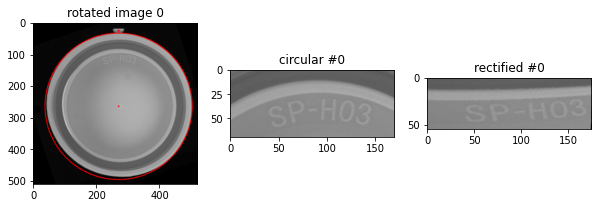

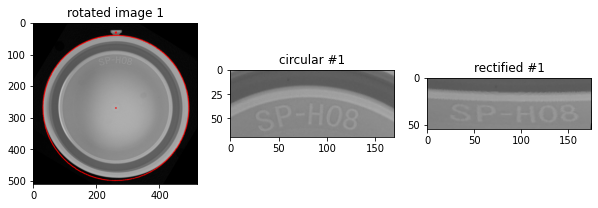

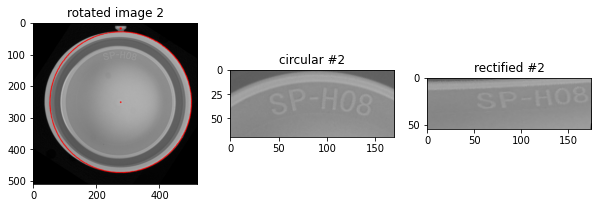

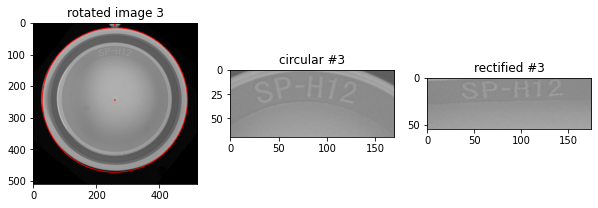

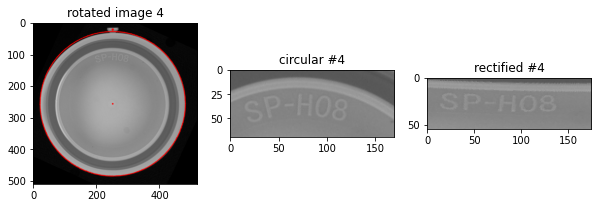

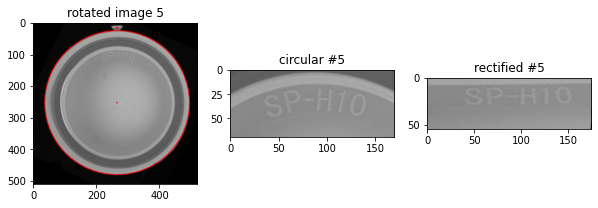

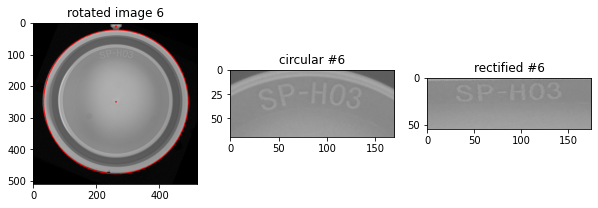

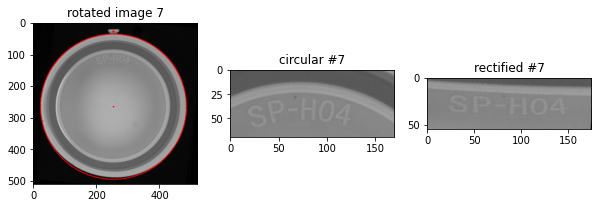

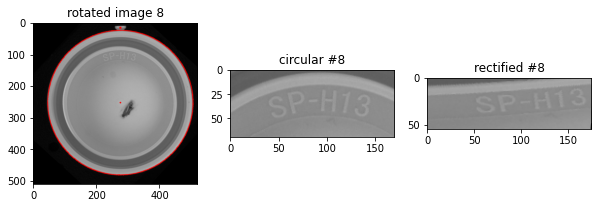

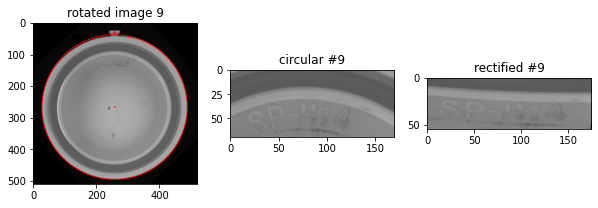

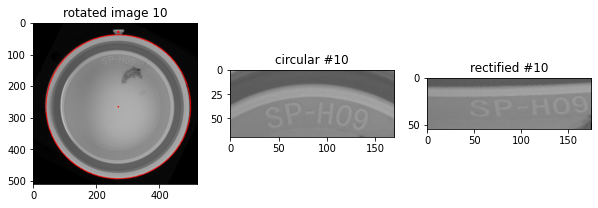

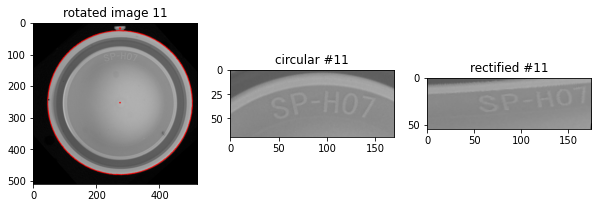

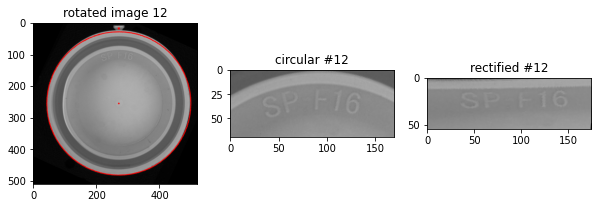

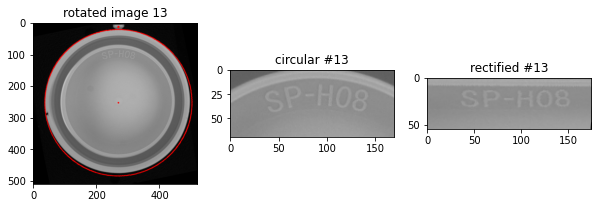

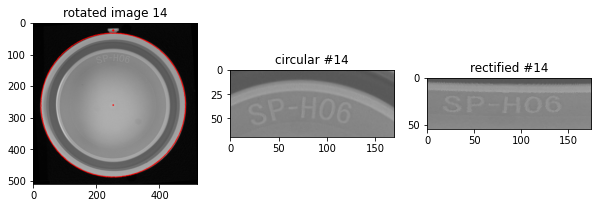

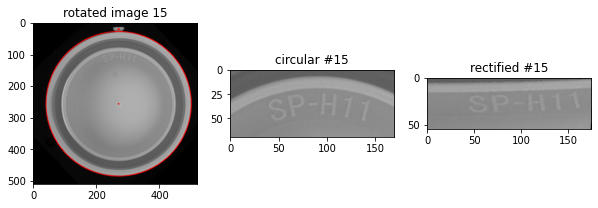

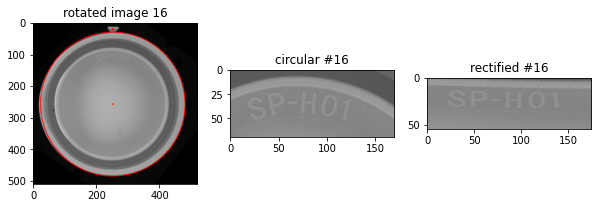

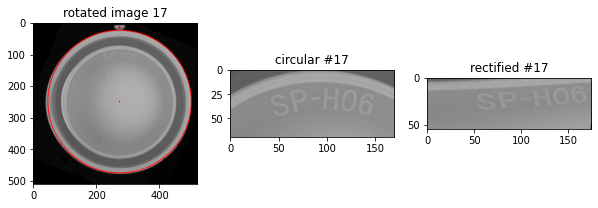

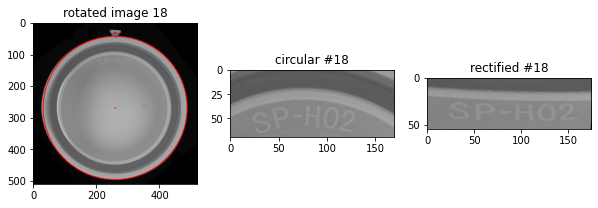

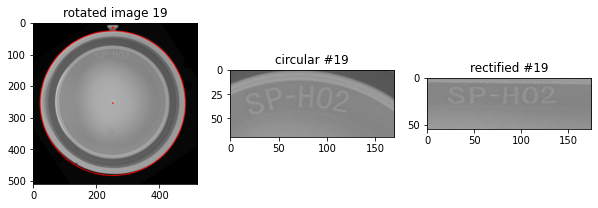

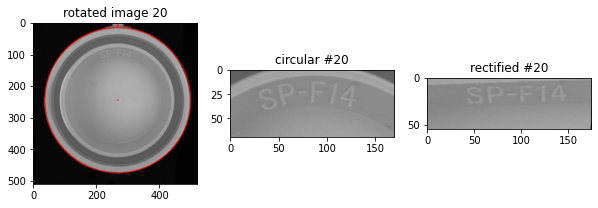

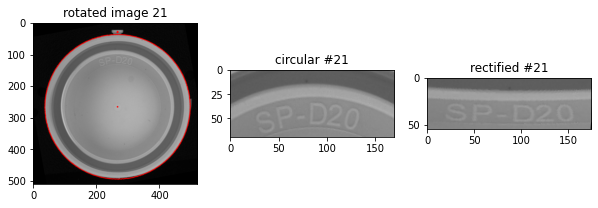

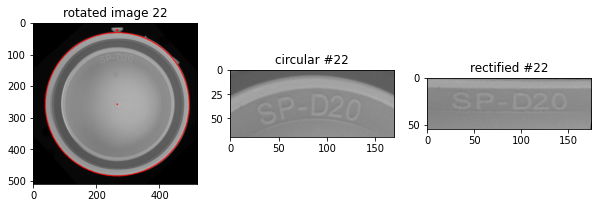

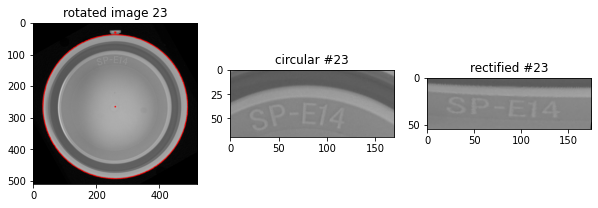

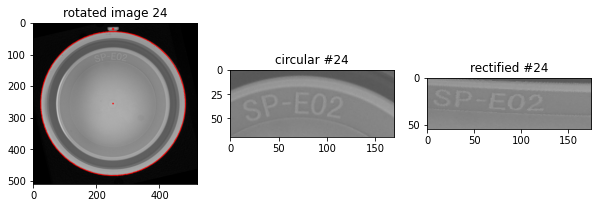

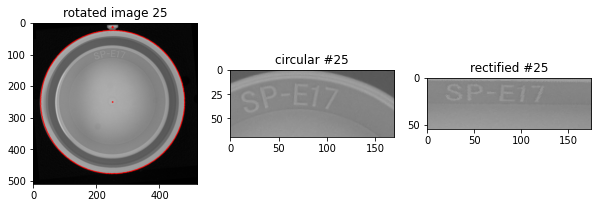

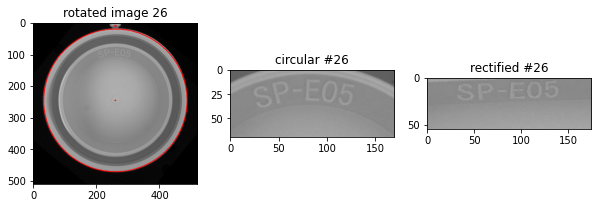

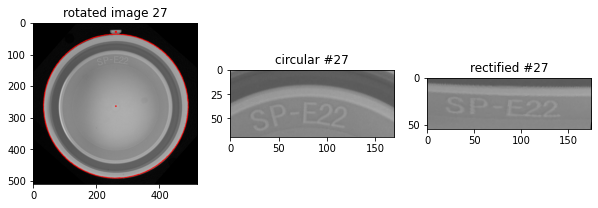

In [50]:
for i in range(len(rotated_images)):
    plt.figure(figsize=(10,15))
    rotated_image = rotated_images[i]
    circular_cavity_num = circular_cav_nums[i]
    rectified_cavity_num_ = rectified_cav_nums[i]
    cv2.imwrite("output\highlighted_{}.bmp".format(i), rotated_image)
    cv2.imwrite("output\circular_cavity_num_{}.bmp".format(i), circular_cavity_num)
    cv2.imwrite("output/rectified_cavity_num_{}.bmp".format(i),rectified_cavity_num_)
    plt.subplot(1,3,1)
    plt.imshow(rotated_image,cmap="gray"),plt.title("rotated image {}".format(i))
    plt.subplot(1,3,2)
    plt.imshow(circular_cavity_num,cmap="gray"),plt.title("circular #{}".format(i))
    plt.subplot(1,3,3)
    plt.imshow(rectified_cavity_num_,cmap="gray"),plt.title("rectified #{}".format(i)),plt.show()